# Trabajo Final Analisis Predictivo_Javier Gilabert Sabater

-----

# Predicciones Finales con los mejores modelos

## Prediccion Serie Reservas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from darts import TimeSeries
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode

In [4]:
#obtain hierarchical dataset
from datasetsforecast.hierarchical import HierarchicalData

# compute base forecast no coherent
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive

In [5]:
mape_reservas = pd.read_csv('mape_reservas.csv')
mape_reservas

,Unnamed: 0,Modelo_Reservas,MAPE
0,0,ARIMA,0.197507
1,2,Best_THETA,0.222124
2,4,TBATS,0.228649
3,1,ETS,0.232204
4,3,Best_4THETA,0.337693


In [6]:
mape_cancelaciones = pd.read_csv('mape_cancelaciones.csv')
mape_cancelaciones

,Unnamed: 0,Modelo_Cancelaciones,MAPE
0,2,Best_THETA,0.547843
1,4,TBATS,0.583951
2,1,ETS,0.602853
3,0,ARIMA,0.641825
4,3,Best_4THETA,0.671182


## Comparando los MAPE's de todos los modelos podemos ver que en el caso de las reservas el mejor modelo para predecir es ARIMA.
## En cambio, para predecir cancelaciones el mejor modelo es best Theta. Ahora pasare a predecir el proximo mes de las reservas y cancelaciones con sus respectivos modelos top.

-----

# Predicciones Reservas (ARIMA)

In [15]:
df_w_r = pd.read_csv('df_reservas.csv')
df_w_r['ArrivalDate'] = pd.to_datetime(df_w_r['ArrivalDate'])
df_w_r = df_w_r.set_index('ArrivalDate')

In [16]:
log_df_w_r = pd.read_csv('df_reservas_LOG.csv')
log_df_w_r = log_df_w_r.rename(columns={'Unnamed: 0': 'ArrivalDate'})
log_df_w_r['ArrivalDate'] = pd.to_datetime(log_df_w_r['ArrivalDate'])
log_df_w_r = log_df_w_r.set_index('ArrivalDate')

In [17]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

In [18]:
y_train, y_test = temporal_train_test_split(y =df_w_r, test_size=4)
log_y_train, log_y_test = temporal_train_test_split(y =log_df_w_r, test_size=4)

In [25]:

fh = np.arange(len(y_test)) + 5  # forecasting horizon

In [21]:
#  Auto ARIMA Model

# Nosotros ajustaremos el modelo con 52 temporadas que son las semanas que tiene un año
forecaster = AutoARIMA(sp=52, suppress_warnings=True)
forecaster.fit(log_y_train)

AutoARIMA(sp=52, suppress_warnings=True)

In [26]:
#  Auto ARIMA Forecast
log_y_pred = forecaster.predict(fh)
log_y_pred

,IsCanceled
2017-09-10,6.053400
2017-09-17,6.089863
2017-09-24,6.091340
2017-10-01,6.078379


In [24]:
#  Auto ARIMA Forecast
# Original Time series (Invert log transformation)
predicciones_reservas = np.exp(log_y_pred)
predicciones_reservas

,IsCanceled
2017-09-10,425.557393
2017-09-17,441.361073
2017-09-24,442.013464
2017-10-01,436.321464


In [35]:
predicciones_reservas.to_csv('Pred_Reservas_Javier_Gilabert.csv')

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

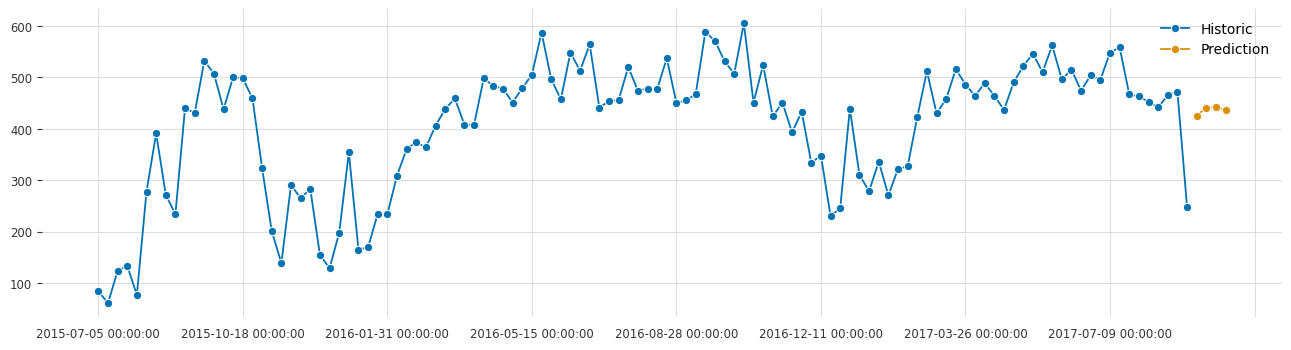

In [34]:
plot_series(df_w_r, predicciones_reservas, labels=["Historic", "Prediction"])

------

# Predicciones Cancelaciones (Best Theta)

In [36]:
#Lectura
df_w_c = pd.read_csv('df_cancelaciones.csv')
df_w_c['ArrivalDate'] = pd.to_datetime(df_w_c['ArrivalDate'])
df_w_c = df_w_c.set_index('ArrivalDate')
df_w_c.tail()

,IsCanceled
ArrivalDate,
2017-08-06,251
2017-08-13,275
2017-08-20,332
2017-08-27,206
2017-09-03,101


In [42]:
df_w_c_theta = df_w_c.copy()
df_w_c_theta.reset_index(level=0, inplace=True)

df_w_c_ts = TimeSeries.from_dataframe(df_w_c_theta,'ArrivalDate','IsCanceled')
train, test = df_w_c_ts.split_before(pd.Timestamp("20170813"))
from darts.models import Theta, FourTheta
from darts.metrics import mape

In [45]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2- np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:

    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(test))
    res = mape(test, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [46]:
best_theta

0.16326530612244916

In [57]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(test)+4)


<TimeSeries (DataArray) (ArrivalDate: 8, component: 1, sample: 1)>
array([[[298.6947017 ]],

       [[254.51910933]],

       [[242.99076875]],

       [[271.91885186]],

       [[231.00052863]],

       [[219.82388178]],

       [[245.14300203]],

       [[207.48194793]]])
Coordinates:
  * ArrivalDate  (ArrivalDate) datetime64[ns] 2017-08-13 ... 2017-10-01
  * component    (component) object 'IsCanceled'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='ArrivalDate'>

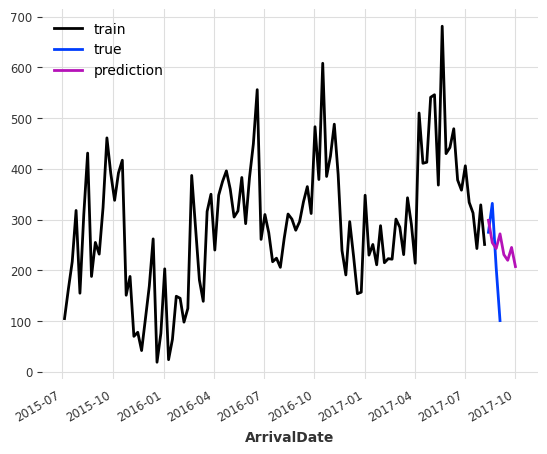

In [58]:
train.plot(label="train")
test.plot(label="true")
pred_best_theta.plot(label="prediction")

In [62]:
pred_best_theta_c = pred_best_theta[4:]
pred_best_theta_c

<TimeSeries (DataArray) (ArrivalDate: 4, component: 1, sample: 1)>
array([[[231.00052863]],

       [[219.82388178]],

       [[245.14300203]],

       [[207.48194793]]])
Coordinates:
  * ArrivalDate  (ArrivalDate) datetime64[ns] 2017-09-10 ... 2017-10-01
  * component    (component) object 'IsCanceled'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [64]:
pred_best_theta.to_csv('Pred_Cancelaciones_Javier_Gilabert.csv')

----